In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import os
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'
queries_dir = './queries/'

In [3]:
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
#cur.execute('SET search_path to {}'.format(schema_name))

In [4]:
# Load in the query from file
query='DROP TABLE IF EXISTS mimiciii.glucoselevels;'
cursor.execute(query)
f = os.path.join(queries_dir,'glucose-levels.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
    
# Execute the query
print('Generating table \'glucoselevels\' using {} ...'.format(f),end=' ')
cursor.execute(query)
print('done.')

Generating table 'glucoselevels' using ./queries/glucose-levels.sql ... done.


In [5]:
query = """
select *
from mimiciii.glucoselevels;
"""
cursor.execute(query)
# Load the result of the query into a dataframe
gl = pd.read_sql_query(query, connect)
gl = gl.replace(to_replace=r'[^0-9]+', value=np.nan, regex=True)


In [6]:
gl.dtypes

subject_id                       int64
hadm_id                          int64
icustay_id                     float64
itemid                           int64
value                           object
charttime               datetime64[ns]
hospital_expire_flag             int64
dtype: object

In [7]:
gl.loc[(gl.value.astype('float') > 1000) & (gl.itemid == 811)].head()

,subject_id,hadm_id,icustay_id,itemid,value,charttime,hospital_expire_flag
42660,391,100095,220320.0,811,1075,2108-09-28 21:09:00,1
63037,494,125330,224081.0,811,1268,2168-02-21 06:45:00,0
108476,1084,152984,212600.0,811,1143,2193-06-25 23:34:00,0
112306,1266,189402,251265.0,811,1191,2106-12-24 05:17:00,0
227961,2066,186403,205798.0,811,1018,2155-09-27 05:38:00,0


In [8]:
gl.loc[(gl.hospital_expire_flag == 1) & (gl.value.astype('float') > 1000)].subject_id.value_counts().head(10)

28666    4
15812    2
10102    2
12532    2
8880     2
10731    2
391      2
10160    1
48826    1
43126    1
Name: subject_id, dtype: int64

In [15]:
gl.loc[gl.subject_id == 517].itemid.value_counts()

3745    2
Name: itemid, dtype: int64

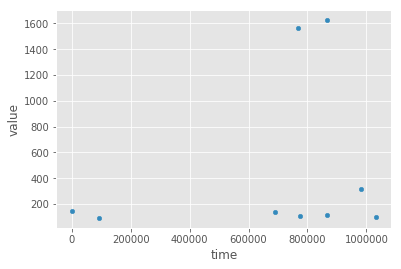

In [10]:
per_sub = gl.loc[(gl.subject_id == 28666) & (gl.itemid == 811)].sort_values(by='charttime')
per_sub['time'] = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()
per_sub['value'] = per_sub['value'].astype('float')
per_sub.plot.scatter(x='time',y='value')

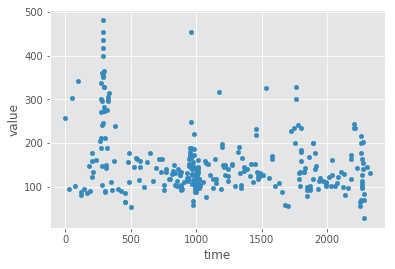

In [37]:
per_sub = gl.loc[(gl.subject_id == 18992) & (gl.itemid == 811)].sort_values(by='charttime')
per_sub['time'] = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
per_sub['value'] = per_sub['value'].astype('float')
per_sub.plot.scatter(x='time',y='value')

In [25]:
gl.subject_id.loc[gl.hospital_expire_flag == 1].value_counts().head()

4894    1716
4902    1257
1785    1061
7666    1013
4914     988
Name: subject_id, dtype: int64

In [33]:
gl.subject_id.loc[gl.hospital_expire_flag == 0].value_counts().head(15)

18992    2077
19911    2033
12613    1753
26519    1705
2187     1508
11861    1483
11923    1418
441      1176
19213    1167
357      1138
24597    1119
3506     1056
20181    1039
3417     1031
23339    1030
Name: subject_id, dtype: int64

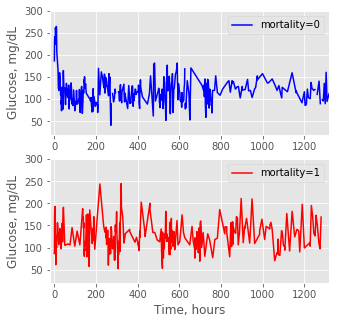

In [93]:
f, axs = plt.subplots(2,1,figsize=(5,5))

per_sub = gl.loc[(gl.subject_id == 24597) & (gl.itemid == 811)].sort_values(by='charttime')
x = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
y = per_sub['value'].astype('float')
axs[0].plot(x,y,'-',color='blue',label='mortality=0')
axs[0].legend(loc='upper right')
#axs[0].set_xlabel('Time, hours')
axs[0].set_ylabel('Glucose, mg/dL')
axs[0].set_xlim(-20, 1320)
axs[0].set_ylim(20, 300)

per_sub = gl.loc[(gl.subject_id == 4902) & (gl.itemid == 811)].sort_values(by='charttime')
x = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
y = per_sub['value'].astype('float')
axs[1].plot(x,y,'-',color='red',label='mortality=1')
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Time, hours')
axs[1].set_ylabel('Glucose, mg/dL')
axs[1].set_xlim(-20, 1320)
axs[1].set_ylim(20, 300)

plt.savefig('glucose.pdf')

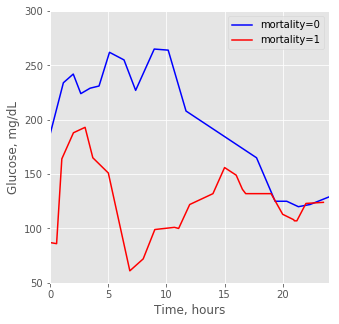

In [94]:
f, axs = plt.subplots(1,1,figsize=(5,5))

per_sub = gl.loc[(gl.subject_id == 24597) & (gl.itemid == 811)].sort_values(by='charttime')
x = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
y = per_sub['value'].astype('float')
axs.plot(x.loc[x<24],y.loc[x<24],'-',color='blue',label='mortality=0')


per_sub = gl.loc[(gl.subject_id == 4902) & (gl.itemid == 811)].sort_values(by='charttime')
x = (per_sub.charttime - per_sub.iloc[0]['charttime']).dt.total_seconds()/3600
y = per_sub['value'].astype('float')
axs.plot(x.loc[x<24],y.loc[x<24],'-',color='red',label='mortality=1')
axs.legend(loc='upper right')
axs.set_xlabel('Time, hours')
axs.set_ylabel('Glucose, mg/dL')
axs.set_xlim(0, 24)
axs.set_ylim(50, 300)

plt.savefig('glucose_24.pdf')